Integrantes del equipo:
- Alonso Cañas Rico
- Hugo Jiménez García

# Parameters

In [1]:
EPOCHS = 20
LEARNING_RATE = 3e-5
BATCH_SIZE = 128
LAYERS_TO_TRAIN = 0

In [2]:
ai_generated_path = "pan24-generative-authorship-news/machines"
human_path = "pan24-generative-authorship-news/human.jsonl"

# Initial config

## Libraries

In [3]:
import os
import json
import pandas as pd
import warnings
import logging
import torch
from torch.utils.data import DataLoader

c:\Users\Hugo\git\NLP\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Device and warmings

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
warnings.filterwarnings("ignore", message=".*overflowing tokens.*")
logging.disable(logging.WARNING)

# Data

## Import data

In [6]:
model, id, text = [], [], []

# Loop through every file in the directory
for filename in os.listdir(ai_generated_path):
    # Check if the file is a JSONL file
    if filename.endswith('.jsonl'):
        filepath = os.path.join(ai_generated_path, filename)
        with open(filepath, 'r', encoding='utf-8') as jsonl_file:
            for line in jsonl_file:
                # Each line is a separate JSON object
                data = json.loads(line)
                model.append(filename)
                id.append(data['id'])
                text.append(data['text'])

df_generated = pd.DataFrame({'model': model, 'id': id, 'text': text, 'ai_generated': 1})
df_generated

,model,id,text,ai_generated
0,alpaca-7b.jsonl,alpaca-7b/news-2021-01-01-2021-12-31-bideninau...,Inaugural Address: President Joseph R. Biden J...,1
1,alpaca-7b.jsonl,alpaca-7b/news-2021-01-01-2021-12-31-bideninau...,Setting the Record Straight: Fact-Checking the...,1
2,alpaca-7b.jsonl,alpaca-7b/news-2021-01-01-2021-12-31-bideninau...,Joe Biden Takes the Oath of Office as 46th Pre...,1
3,alpaca-7b.jsonl,alpaca-7b/news-2021-01-01-2021-12-31-bideninau...,Joe Biden Takes Oath as 46th President of Unit...,1
4,alpaca-7b.jsonl,alpaca-7b/news-2021-01-01-2021-12-31-bideninau...,Amanda Gorman's Inspiring Poem Celebrates Hope...,1
...,...,...,...,...
14126,vicgalle-gpt2-open-instruct-v1.jsonl,vicgalle-gpt2-open-instruct-v1/news-2021-01-01...,'The Disappearance of Gabby Petito' – A Compre...,1
14127,vicgalle-gpt2-open-instruct-v1.jsonl,vicgalle-gpt2-open-instruct-v1/news-2021-01-01...,"Utah State Police Search for Gabby Petito, Tra...",1
14128,vicgalle-gpt2-open-instruct-v1.jsonl,vicgalle-gpt2-open-instruct-v1/news-2021-01-01...,McKenna's Lost Friend: Debunking the Evidence ...,1
14129,vicgalle-gpt2-open-instruct-v1.jsonl,vicgalle-gpt2-open-instruct-v1/news-2021-01-01...,"""Gunshots Found in Florida Nature Preserve: A ...",1


In [7]:
id, text = [], []

with open(human_path, 'r', encoding='utf-8') as jsonl_file:
    for line in jsonl_file:
        # Each line is a separate JSON object
        data = json.loads(line)
        id.append(data['id'])
        text.append(data['text'])

df_human = pd.DataFrame({'model': 'Human', 'id': id, 'text': text, 'ai_generated': 0})
df_human

,model,id,text,ai_generated
0,Human,articles-cleaned-truncated/news-2021-01-01-202...,Inaugural Address by President Joseph R. Biden...,0
1,Human,articles-cleaned-truncated/news-2021-01-01-202...,Fact check: Biden inauguration impacted by pan...,0
2,Human,articles-cleaned-truncated/news-2021-01-01-202...,Highlights from Joe Biden's 2021 inauguration\...,0
3,Human,articles-cleaned-truncated/news-2021-01-01-202...,"Biden takes the helm, appeals for unity to tak...",0
4,Human,articles-cleaned-truncated/news-2021-01-01-202...,'The Hill We Climb': Read Amanda Gorman's inau...,0
...,...,...,...,...
1082,Human,articles-cleaned-truncated/news-2021-01-01-202...,How amateur detectives on social media helped ...,0
1083,Human,articles-cleaned-truncated/news-2021-01-01-202...,Authorities searching for missing 22-year-old ...,0
1084,Human,articles-cleaned-truncated/news-2021-01-01-202...,Univ. of Wisconsin Oshkosh student helping Gab...,0
1085,Human,articles-cleaned-truncated/news-2021-01-01-202...,Did the Internet Actually Help Find Gabby Peti...,0


In [8]:
df = pd.concat([df_generated, df_human])
df

,model,id,text,ai_generated
0,alpaca-7b.jsonl,alpaca-7b/news-2021-01-01-2021-12-31-bideninau...,Inaugural Address: President Joseph R. Biden J...,1
1,alpaca-7b.jsonl,alpaca-7b/news-2021-01-01-2021-12-31-bideninau...,Setting the Record Straight: Fact-Checking the...,1
2,alpaca-7b.jsonl,alpaca-7b/news-2021-01-01-2021-12-31-bideninau...,Joe Biden Takes the Oath of Office as 46th Pre...,1
3,alpaca-7b.jsonl,alpaca-7b/news-2021-01-01-2021-12-31-bideninau...,Joe Biden Takes Oath as 46th President of Unit...,1
4,alpaca-7b.jsonl,alpaca-7b/news-2021-01-01-2021-12-31-bideninau...,Amanda Gorman's Inspiring Poem Celebrates Hope...,1
...,...,...,...,...
1082,Human,articles-cleaned-truncated/news-2021-01-01-202...,How amateur detectives on social media helped ...,0
1083,Human,articles-cleaned-truncated/news-2021-01-01-202...,Authorities searching for missing 22-year-old ...,0
1084,Human,articles-cleaned-truncated/news-2021-01-01-202...,Univ. of Wisconsin Oshkosh student helping Gab...,0
1085,Human,articles-cleaned-truncated/news-2021-01-01-202...,Did the Internet Actually Help Find Gabby Peti...,0


## Process Data - Todas las posibles combinaciones

In [9]:
# from sklearn.model_selection import train_test_split

# test_size = 0.2
# val_size = 0.1
# _adjusted_val_size = val_size / (1 - test_size)

# # Assume X is your features and y is your target variable
# X_train_val, X_test, y_train_val, y_test = train_test_split(df.drop(columns=['ai_generated']), df['ai_generated'], test_size=test_size, stratify=df['ai_generated'], shuffle=True, random_state=1337)
# X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=_adjusted_val_size, stratify=y_train_val, shuffle=True, random_state=1337)
# X_train.reset_index(drop=True, inplace=True)
# y_train.reset_index(drop=True, inplace=True)
# X_val.reset_index(drop=True, inplace=True)
# y_val.reset_index(drop=True, inplace=True)
# X_test.reset_index(drop=True, inplace=True)
# y_test.reset_index(drop=True, inplace=True)
# # Print the dimensions
# print(f"X_train shape: {X_train.shape} / AI generated count: {y_train.value_counts()[1]} - Human count: {y_train.value_counts()[0]}")
# print(f"y_train shape: {y_train.shape}")
# print(f"X_val shape: {X_val.shape} / AI generated count: {y_val.value_counts()[1]} - Human count: {y_val.value_counts()[0]}")
# print(f"y_val shape: {y_val.shape}")
# print(f"X_test shape: {X_test.shape} / AI generated count: {y_test.value_counts()[1]} - Human count: {y_test.value_counts()[0]}")
# print(f"y_test shape: {y_test.shape}")

## Process Data - Combinaciones únicamente del mismo id

In [10]:
from sklearn.model_selection import train_test_split
import pandas as pd

test_size = 0.25
val_size = 0.125
_adjusted_val_size = val_size / (1 - test_size)

# Extraer el segundo y tercer segmento de los IDs
df['base_id'] = df['id'].apply(lambda x: '/'.join(x.split('/')[1:]))  # Coger los ids sin la parte que identifica al autor del fragmento de texto.

# Paso 1: Dividir los datos según los `base_id`
base_ids = df['base_id'].unique()
train_base_ids, test_base_ids = train_test_split(base_ids, test_size=test_size, random_state=1337)
train_base_ids, val_base_ids = train_test_split(train_base_ids, test_size=_adjusted_val_size, random_state=1337) 

# Crear DataFrames por conjunto
train = df[df['base_id'].isin(train_base_ids)]
val = df[df['base_id'].isin(val_base_ids)]
test = df[df['base_id'].isin(test_base_ids)]

train.reset_index(drop=True, inplace=True)
val.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

print(f"train shape: {train.shape}")
print(f"val shape: {val.shape}")
print(f"test shape: {test.shape}")

train shape: (9506, 5)
val shape: (1904, 5)
test shape: (3808, 5)


In [11]:
def create_combinations_within_id(df):
    # Lista para almacenar las combinaciones de cada `base_id`
    combinations = []
    
    # Iterar sobre cada `base_id`
    for _, group in df.groupby('base_id'):
        # Filtrar textos humanos e IA dentro del grupo
        df_human = group[group['ai_generated'] == 0][['text']].reset_index(drop=True)
        df_ia = group[group['ai_generated'] == 1][['text']].reset_index(drop=True)
        
        # Producto cartesiano dentro del `base_id`
        cartesian_df = df_human.merge(df_ia, how='cross', suffixes=('_human', '_ia'))
        cartesian_df = cartesian_df.sample(frac=1).reset_index(drop=True)
        
        # Crear las dos disposiciones
        total_combinations = len(cartesian_df)
        
        half_1 = cartesian_df.iloc[:total_combinations // 2].copy()
        half_1['comment_text_1'] = half_1['text_human']
        half_1['comment_text_2'] = half_1['text_ia']
        half_1['list'] = 0  # Etiqueta 0
        
        half_2 = cartesian_df.iloc[total_combinations // 2:].copy()
        half_2['comment_text_1'] = half_2['text_ia']
        half_2['comment_text_2'] = half_2['text_human']
        half_2['list'] = 1  # Etiqueta 1
        
        # Combinar y agregar al resultado final
        balanced_df = pd.concat([half_1, half_2], ignore_index=True)
        combinations.append(balanced_df)
    
    # Concatenar todas las combinaciones y barajar
    return pd.concat(combinations, ignore_index=True).sample(frac=1).reset_index(drop=True)


In [12]:
# Generar combinaciones restringidas por `id` para cada conjunto
train = create_combinations_within_id(train)
val = create_combinations_within_id(val)
test = create_combinations_within_id(test)

In [13]:
# Print the dimensions
print(f"train shape: {train.shape} / Text on comment_text_1 is human-generated: {train['list'].value_counts()[0]} - Text on comment_text_2 is human-generated: {train['list'].value_counts()[1]}")
print(f"val shape: {val.shape} / Text on comment_text_1 is human-generated: {val['list'].value_counts()[0]} - Text on comment_text_2 is human-generated: {val['list'].value_counts()[1]}")
print(f"test shape: {test.shape} / Text on comment_text_1 is human-generated: {test['list'].value_counts()[0]} - Text on comment_text_2 is human-generated: {test['list'].value_counts()[1]}")

train shape: (8827, 5) / Text on comment_text_1 is human-generated: 4074 - Text on comment_text_2 is human-generated: 4753
val shape: (1768, 5) / Text on comment_text_1 is human-generated: 816 - Text on comment_text_2 is human-generated: 952
test shape: (3536, 5) / Text on comment_text_1 is human-generated: 1632 - Text on comment_text_2 is human-generated: 1904


# Model

In [14]:
# Use a pipeline as a high-level helper
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import pipeline
from transformers import BertTokenizer, BertModel

# pipe = pipeline("text-classification", model="Lau123/distilbert-base-uncased-detect_ai_generated_text")
# model_name = "Lau123/distilbert-base-uncased-detect_ai_generated_text"
# tokenizer = DistilBertTokenizer.from_pretrained(model_name)
# individual_model =  DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)

model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
individual_model =  BertModel.from_pretrained(model_name)
individual_model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [15]:
for param in individual_model.parameters():
    param.requires_grad = False
if LAYERS_TO_TRAIN > 0:
    for layer in individual_model.encoder.layer[-LAYERS_TO_TRAIN:]:
        for param in layer.parameters():
            param.requires_grad = True

for param in individual_model.pooler.dense.parameters():
    param.requires_grad = True

# Verify that only the classifier layer is trainable
for name, param in individual_model.named_parameters():
    print(f"{name}: requires_grad = {param.requires_grad}")

embeddings.word_embeddings.weight: requires_grad = False
embeddings.position_embeddings.weight: requires_grad = False
embeddings.token_type_embeddings.weight: requires_grad = False
embeddings.LayerNorm.weight: requires_grad = False
embeddings.LayerNorm.bias: requires_grad = False
encoder.layer.0.attention.self.query.weight: requires_grad = False
encoder.layer.0.attention.self.query.bias: requires_grad = False
encoder.layer.0.attention.self.key.weight: requires_grad = False
encoder.layer.0.attention.self.key.bias: requires_grad = False
encoder.layer.0.attention.self.value.weight: requires_grad = False
encoder.layer.0.attention.self.value.bias: requires_grad = False
encoder.layer.0.attention.output.dense.weight: requires_grad = False
encoder.layer.0.attention.output.dense.bias: requires_grad = False
encoder.layer.0.attention.output.LayerNorm.weight: requires_grad = False
encoder.layer.0.attention.output.LayerNorm.bias: requires_grad = False
encoder.layer.0.intermediate.dense.weight: requ

In [16]:
from transformers import BertModel
import torch
import torch.nn.functional as F


class TransformerClass(torch.nn.Module):
    def __init__(self, individual_model):
        super(TransformerClass, self).__init__()
        self.l1 = individual_model
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 1)
        self.l4 = torch.nn.Sigmoid()
    
    def __predict(self, ids, mask, token_type_ids):
        x = self.l1(ids, attention_mask=mask, token_type_ids=token_type_ids).last_hidden_state[:, 0]
        x = self.l2(x)
        x = self.l3(x)
        x = self.l4(x)
        return x

    def forward(self, ids_0, mask_0, token_type_ids_0, ids_1, mask_1, token_type_ids_1):
        # outputs1 = self.individual_model(input_ids=ids_0, attention_mask=mask_0)
        p1_human = self.__predict(ids_0, mask_0, token_type_ids_0)
        # outputs2 = self.individual_model(input_ids=ids_1, attention_mask=mask_1)
        p2_human = self.__predict(ids_1, mask_1, token_type_ids_1)

        # probs1 = torch.softmax(outputs1.logits, dim=-1).detach().cpu().numpy()
        # probs2 = torch.softmax(outputs2.logits, dim=-1).detach().cpu().numpy()
        # p1_human, p2_human = probs1[:, 0], probs2[:, 0]
        # prob_text2_human = p2_human / (p1_human + p2_human)
        # return torch.tensor(prob_text2_human.reshape(-1, 1))
    
        # probs1 = torch.softmax(outputs1.logits, dim=-1)
        # probs2 = torch.softmax(outputs2.logits, dim=-1)
        # p1_human, p2_human = probs1[:, 0], probs2[:, 0]
        # prob_text2_human = p2_human / (p1_human + p2_human)
        return p2_human / (p1_human + p2_human)
        # return prob_text2_human.unsqueeze(-1)


model = TransformerClass(individual_model)
model.to(device)

TransformerClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

# Training

## Loss and optimizer

In [17]:
from transformers import AdamW

loss_fn = torch.nn.BCELoss()
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

c:\Users\Hugo\git\NLP\venv\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Data Generators

In [18]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment_text_1 = dataframe.comment_text_1
        self.comment_text_2 = dataframe.comment_text_2
        self.targets = self.data.list
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        comment_text_1 = str(self.comment_text_1[index])
        comment_text_1 = " ".join(comment_text_1.split())
        comment_text_2 = str(self.comment_text_2[index])
        comment_text_2 = " ".join(comment_text_2.split())
        inputs0 = self.tokenizer(comment_text_1, 
                                max_length=self.max_len,
                                padding="max_length",
                                truncation=True,
                                return_overflowing_tokens=False,
                                return_token_type_ids=True)
        inputs1 = self.tokenizer(comment_text_2,
                                max_length=self.max_len,
                                padding="max_length",
                                truncation=True,
                                return_overflowing_tokens=False,
                                return_token_type_ids=True)
        return {
            'ids_0': torch.tensor(inputs0.input_ids, dtype=torch.long),
            'mask_0': torch.tensor(inputs0.attention_mask, dtype=torch.long),
            'token_type_ids_0': torch.tensor(inputs0.token_type_ids, dtype=torch.long),
            'ids_1': torch.tensor(inputs1.input_ids, dtype=torch.long),
            'mask_1': torch.tensor(inputs1.attention_mask, dtype=torch.long),
            'token_type_ids_1': torch.tensor(inputs1.token_type_ids, dtype=torch.long),
            'labels': torch.tensor(self.targets[index], dtype=torch.long)
          }

In [19]:
# Instancia el dataset
train_dataset = CustomDataset(dataframe=train, tokenizer=tokenizer, max_len=512)
val_dataset = CustomDataset(dataframe=val, tokenizer=tokenizer, max_len=512)
test_dataset = CustomDataset(dataframe=test, tokenizer=tokenizer, max_len=512)

In [20]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

## Training and metrics methods

In [21]:
def c_at_1(targets, preds):
    """
    Calculates the C@1 metric:
    - Non-answers (predictions marked as -1) are given a score of 0.5.
    - Remaining cases are scored based on accuracy.
    
    Parameters:
        targets (np.array): Ground truth labels.
        preds (np.array): Predictions, where -1 indicates a non-answer.
    
    Returns:
        float: C@1 metric.
    """
    correct = (targets == preds)  # Boolean array for correct predictions
    unanswered = preds == -1     # Boolean array for non-answers
    
    num_correct = correct.sum()
    num_total = len(targets)
    num_unanswered = unanswered.sum()
    
    return (num_correct + num_unanswered * 0.5) / num_total

In [22]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, brier_score_loss, fbeta_score
import numpy as np
from tqdm import tqdm


# Función de entrenamiento
def train_epoch(model, loader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0

    # Use tqdm to wrap the loader for a progress bar
    for batch in tqdm(loader, desc="Training", leave=True):
        labels = batch['labels'].unsqueeze(1).to(device).float()
        batch = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        outputs = model(**batch)

        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(loader)


# Función de evaluación
def evaluate(model, loader, device):
    model.eval()
    preds, targets, probabilities = [], [], []

    with torch.no_grad():
        for batch in loader:
            labels = batch['labels'].unsqueeze(1).float()
            batch = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            outputs = model(**batch)
            probabilities.extend(outputs.cpu().numpy())
            preds.extend(torch.round(outputs).cpu().numpy())
            targets.extend(labels.cpu().numpy())
    
    targets = np.array(targets).flatten()
    preds = np.array(preds).flatten()
    probabilities = np.array(probabilities).flatten()
    
    # Calculate metrics
    roc_auc = roc_auc_score(targets, probabilities)
    brier = brier_score_loss(targets, probabilities)
    f1 = f1_score(targets, preds)
    f05u = fbeta_score(targets, preds, beta=0.5)
    c1 = c_at_1(targets, preds)
    mean = np.mean([roc_auc, 1- brier, c1, f1, f05u])
    
    return {
        "accuracy": accuracy_score(targets, preds),
        "roc-auc": roc_auc,
        "brier": brier,
        "c@1": c1,
        "f1": f1,
        "f05u": f05u,
        "mean": mean,
    }

## Training

In [23]:
history = {
    "train_loss": [],
    "train_metrics": [],
    "val_metrics": []
}

save_path = f"models/models_individual_bert_congelado/fine_tuned_model_{EPOCHS}_epochs_{LEARNING_RATE}_lr_{LAYERS_TO_TRAIN}_layers_{BATCH_SIZE}_batch_size"


# Entrenamiento y validación
for epoch in range(EPOCHS):
    print(f"Starting Epoch {epoch + 1}/{EPOCHS}")
    print("* Training")
    train_loss = train_epoch(model, train_loader, optimizer, loss_fn, device)

    print("* Saving model")
    _epoch_save_path = f"{save_path}_checkpoint_{epoch + 1}.pth"
    torch.save(model, _epoch_save_path)

    print("* Calculating metrics for training")
    train_metrics = evaluate(model, train_loader, device)
    print("* Calculating metrics for validation")
    val_metrics = evaluate(model, val_loader, device)

    history["train_loss"].append(train_loss)
    history["train_metrics"].append(train_metrics)
    history["val_metrics"].append(val_metrics)

    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print(f"Train Loss: {train_loss}")
    print("Train Metrics:")
    for metric_name, value in train_metrics.items():
        print(f"  {metric_name}: {value}")
    print("Validation Metrics:")
    for metric_name, value in val_metrics.items():
        print(f"  {metric_name}: {value}")

Starting Epoch 1/20
* Training


Training: 100%|██████████| 69/69 [02:48<00:00,  2.44s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 1/20
Train Loss: 0.6793302185293557
Train Metrics:
  accuracy: 0.7267474793247989
  roc-auc: 0.8031096759187103
  brier: 0.23530592462826516
  c@1: 0.7267474793247989
  f1: 0.7407009245323586
  f05u: 0.7505773672055428
  mean: 0.757165904470629
Validation Metrics:
  accuracy: 0.7579185520361991
  roc-auc: 0.8244665513264129
  brier: 0.23356977565693987
  c@1: 0.7579185520361991
  f1: 0.7713675213675214
  f05u: 0.7793609671848014
  mean: 0.779908763251599
Starting Epoch 2/20
* Training


Training: 100%|██████████| 69/69 [02:37<00:00,  2.28s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 2/20
Train Loss: 0.6497508650240691
Train Metrics:
  accuracy: 0.8447943808768551
  roc-auc: 0.9220411241185965
  brier: 0.21852767726842873
  c@1: 0.8447943808768551
  f1: 0.8541622312114115
  f05u: 0.8603165072693745
  mean: 0.8525573132415618
Validation Metrics:
  accuracy: 0.872737556561086
  roc-auc: 0.9368859676223431
  brier: 0.2149766760312139
  c@1: 0.872737556561086
  f1: 0.8813916710595677
  f05u: 0.8833474218089603
  mean: 0.8718771882041487
Starting Epoch 3/20
* Training


Training: 100%|██████████| 69/69 [02:38<00:00,  2.30s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 3/20
Train Loss: 0.6181174672168234
Train Metrics:
  accuracy: 0.8899966013368075
  roc-auc: 0.9555323093359841
  brier: 0.19971460015015244
  c@1: 0.8899966013368075
  f1: 0.8972812863641172
  f05u: 0.9003099392858658
  mean: 0.8886811072345244
Validation Metrics:
  accuracy: 0.9179864253393665
  roc-auc: 0.9657030091448344
  brier: 0.1942881890378153
  c@1: 0.9179864253393665
  f1: 0.9233209941829719
  f05u: 0.92714528462192
  mean: 0.9079735048502554
Starting Epoch 4/20
* Training


Training: 100%|██████████| 69/69 [02:37<00:00,  2.29s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 4/20
Train Loss: 0.5814088306565216
Train Metrics:
  accuracy: 0.9083493825761867
  roc-auc: 0.9658572096831385
  brier: 0.1807049410173498
  c@1: 0.9083493825761867
  f1: 0.914527205493925
  f05u: 0.9169103004109994
  mean: 0.90498783142938
Validation Metrics:
  accuracy: 0.9304298642533937
  roc-auc: 0.9744938416543087
  brier: 0.17357153790307642
  c@1: 0.9304298642533937
  f1: 0.9350923482849604
  f05u: 0.9377646062658763
  mean: 0.9208418245110925
Starting Epoch 5/20
* Training


Training: 100%|██████████| 69/69 [02:35<00:00,  2.26s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 5/20
Train Loss: 0.5467895113903544
Train Metrics:
  accuracy: 0.9160530191458026
  roc-auc: 0.9701120218519973
  brier: 0.16337331363636626
  c@1: 0.9160530191458026
  f1: 0.9219095795131204
  f05u: 0.9229016331181161
  mean: 0.9135205879985341
Validation Metrics:
  accuracy: 0.9315610859728507
  roc-auc: 0.9780956500247158
  brier: 0.15494338575608058
  c@1: 0.9315610859728507
  f1: 0.93608029582673
  f05u: 0.9393553859202716
  mean: 0.9260298063976975
Starting Epoch 6/20
* Training


Training: 100%|██████████| 69/69 [02:35<00:00,  2.26s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 6/20
Train Loss: 0.512475071609884
Train Metrics:
  accuracy: 0.919791548657528
  roc-auc: 0.9723075450060684
  brier: 0.14841765303575358
  c@1: 0.919791548657528
  f1: 0.9254265852117127
  f05u: 0.926128937049374
  mean: 0.9190473925777859
Validation Metrics:
  accuracy: 0.9349547511312217
  roc-auc: 0.9798141683143846
  brier: 0.13913957732778492
  c@1: 0.9349547511312217
  f1: 0.93918561607615
  f05u: 0.9430756159728123
  mean: 0.9315781148333568
Starting Epoch 7/20
* Training


Training: 100%|██████████| 69/69 [02:35<00:00,  2.26s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 7/20
Train Loss: 0.483101748469947
Train Metrics:
  accuracy: 0.9219440353460973
  roc-auc: 0.9738486226976403
  brier: 0.13587360054541636
  c@1: 0.9219440353460973
  f1: 0.927404909914656
  f05u: 0.9282851719046615
  mean: 0.9231218278635277
Validation Metrics:
  accuracy: 0.9383484162895928
  roc-auc: 0.9811040224913493
  brier: 0.12603166256813564
  c@1: 0.9383484162895928
  f1: 0.9423585404547858
  f05u: 0.9462616822429906
  mean: 0.9364081997821165
Starting Epoch 8/20
* Training


Training: 100%|██████████| 69/69 [02:35<00:00,  2.25s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 8/20
Train Loss: 0.45838138720263605
Train Metrics:
  accuracy: 0.9254559873116575
  roc-auc: 0.9752057481511043
  brier: 0.12530677774987406
  c@1: 0.9254559873116575
  f1: 0.9306346194391736
  f05u: 0.9318133839983112
  mean: 0.9275605922300745
Validation Metrics:
  accuracy: 0.9400452488687783
  roc-auc: 0.9820784931619706
  brier: 0.11517087483089576
  c@1: 0.9400452488687783
  f1: 0.9439746300211416
  f05u: 0.9475806451612904
  mean: 0.939701628476457
Starting Epoch 9/20
* Training


Training: 100%|██████████| 69/69 [02:35<00:00,  2.25s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 9/20
Train Loss: 0.43611126965370733
Train Metrics:
  accuracy: 0.9279483403194744
  roc-auc: 0.9764685219091661
  brier: 0.11645584343198649
  c@1: 0.9279483403194744
  f1: 0.9330103223088267
  f05u: 0.9337184298182738
  mean: 0.9309379541847509
Validation Metrics:
  accuracy: 0.9411764705882353
  roc-auc: 0.9829525560224088
  brier: 0.10616737220709362
  c@1: 0.9411764705882353
  f1: 0.9450897571277719
  f05u: 0.9480932203389831
  mean: 0.9422289263740611
Starting Epoch 10/20
* Training


Training: 100%|██████████| 69/69 [02:36<00:00,  2.26s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 10/20
Train Loss: 0.41658791251804517
Train Metrics:
  accuracy: 0.9298742494618784
  roc-auc: 0.9775525335470112
  brier: 0.10885916737479231
  c@1: 0.9298742494618784
  f1: 0.934835245815349
  f05u: 0.935248767746556
  mean: 0.9337303258392005
Validation Metrics:
  accuracy: 0.9428733031674208
  roc-auc: 0.9837815640962267
  brier: 0.09851014623242689
  c@1: 0.9428733031674208
  f1: 0.9467018469656991
  f05u: 0.9494072819644369
  mean: 0.9448507699922712
Starting Epoch 11/20
* Training


Training: 100%|██████████| 69/69 [02:35<00:00,  2.26s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 11/20
Train Loss: 0.3989308234574138
Train Metrics:
  accuracy: 0.931347003511952
  roc-auc: 0.97857896327989
  brier: 0.10245290375713478
  c@1: 0.931347003511952
  f1: 0.9361836562763269
  f05u: 0.9367755532139094
  mean: 0.9360864545049887
Validation Metrics:
  accuracy: 0.9451357466063348
  roc-auc: 0.9844960042840666
  brier: 0.0921526057947111
  c@1: 0.9451357466063348
  f1: 0.9487585842577919
  f05u: 0.9520780322307039
  mean: 0.9476631523168372
Starting Epoch 12/20
* Training


Training: 100%|██████████| 69/69 [02:35<00:00,  2.25s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 12/20
Train Loss: 0.38139649534570996
Train Metrics:
  accuracy: 0.9330463351081908
  roc-auc: 0.9794746072061973
  brier: 0.09683524451054114
  c@1: 0.9330463351081908
  f1: 0.9377436005477721
  f05u: 0.9385147387508961
  mean: 0.938388807420503
Validation Metrics:
  accuracy: 0.9468325791855203
  roc-auc: 0.9851486550502554
  brier: 0.08660108455526215
  c@1: 0.9468325791855203
  f1: 0.9503695881731784
  f05u: 0.9533898305084746
  mean: 0.9498279136724334
Starting Epoch 13/20
* Training


Training: 100%|██████████| 69/69 [02:35<00:00,  2.26s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 13/20
Train Loss: 0.37145056413567584
Train Metrics:
  accuracy: 0.9344058003851818
  roc-auc: 0.980288345391449
  brier: 0.09200465777115575
  c@1: 0.9344058003851818
  f1: 0.9390076898767513
  f05u: 0.9397798675831823
  mean: 0.9402954090930817
Validation Metrics:
  accuracy: 0.9485294117647058
  roc-auc: 0.9857446655132642
  brier: 0.08187374627171877
  c@1: 0.9485294117647058
  f1: 0.9519281563655573
  f05u: 0.9552586938083123
  mean: 0.9519174362360243
Starting Epoch 14/20
* Training


Training: 100%|██████████| 69/69 [02:36<00:00,  2.27s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 14/20
Train Loss: 0.3543299825295158
Train Metrics:
  accuracy: 0.9354253993429251
  roc-auc: 0.9810425650605809
  brier: 0.08762824871174558
  c@1: 0.9354253993429251
  f1: 0.94
  f05u: 0.9403563455625289
  mean: 0.9418392122508579
Validation Metrics:
  accuracy: 0.9479638009049773
  roc-auc: 0.9862724501565332
  brier: 0.07762034437679759
  c@1: 0.9479638009049773
  f1: 0.9513742071881608
  f05u: 0.9550084889643465
  mean: 0.9525997205674439
Starting Epoch 15/20
* Training


Training: 100%|██████████| 69/69 [02:35<00:00,  2.26s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 15/20
Train Loss: 0.3428738134494726
Train Metrics:
  accuracy: 0.9366715758468336
  roc-auc: 0.9818429018966498
  brier: 0.08369952664057094
  c@1: 0.9366715758468336
  f1: 0.9411517001789663
  f05u: 0.9415680161772763
  mean: 0.943506933491831
Validation Metrics:
  accuracy: 0.9502262443438914
  roc-auc: 0.9868684606195419
  brier: 0.07382800744171543
  c@1: 0.9502262443438914
  f1: 0.9534883720930232
  f05u: 0.9571307300509337
  mean: 0.954777159933135
Starting Epoch 16/20
* Training


Training: 100%|██████████| 69/69 [02:35<00:00,  2.26s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 16/20
Train Loss: 0.33347437606341596
Train Metrics:
  accuracy: 0.9373513084853291
  roc-auc: 0.9825330068258572
  brier: 0.08020193542002842
  c@1: 0.9373513084853291
  f1: 0.9417465500895398
  f05u: 0.9425209800531356
  mean: 0.9447899820067667
Validation Metrics:
  accuracy: 0.9502262443438914
  roc-auc: 0.9873151466468941
  brier: 0.07048188276351809
  c@1: 0.9502262443438914
  f1: 0.9534883720930232
  f05u: 0.9571307300509337
  mean: 0.9555357220742449
Starting Epoch 17/20
* Training


Training: 100%|██████████| 69/69 [02:35<00:00,  2.25s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 17/20
Train Loss: 0.32593248028686084
Train Metrics:
  accuracy: 0.9401835278123938
  roc-auc: 0.9832443886562717
  brier: 0.07699532498004802
  c@1: 0.9401835278123938
  f1: 0.9443859279544976
  f05u: 0.9451026689716238
  mean: 0.9471842376829478
Validation Metrics:
  accuracy: 0.9502262443438914
  roc-auc: 0.9878905606360191
  brier: 0.06743242948003565
  c@1: 0.9502262443438914
  f1: 0.9535374868004223
  f05u: 0.9565677966101697
  mean: 0.9561579317820932
Starting Epoch 18/20
* Training


Training: 100%|██████████| 69/69 [02:35<00:00,  2.25s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 18/20
Train Loss: 0.315933991169584
Train Metrics:
  accuracy: 0.9406366829047241
  roc-auc: 0.9838968975076177
  brier: 0.07409295160094467
  c@1: 0.9406366829047241
  f1: 0.9448072466821149
  f05u: 0.9455243074587847
  mean: 0.9481544365904593
Validation Metrics:
  accuracy: 0.9513574660633484
  roc-auc: 0.9883308102652826
  brier: 0.06469609244357526
  c@1: 0.9513574660633484
  f1: 0.9545454545454546
  f05u: 0.9581918505942276
  mean: 0.9575458978049476
Starting Epoch 19/20
* Training


Training: 100%|██████████| 69/69 [02:36<00:00,  2.26s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 19/20
Train Loss: 0.3081741708776225
Train Metrics:
  accuracy: 0.9422227257278804
  roc-auc: 0.9845525307582912
  brier: 0.07142403160376806
  c@1: 0.9422227257278804
  f1: 0.946259220231823
  f05u: 0.9472174169866251
  mean: 0.9497655724201703
Validation Metrics:
  accuracy: 0.9530542986425339
  roc-auc: 0.9888212637996375
  brier: 0.062193227612380074
  c@1: 0.9530542986425339
  f1: 0.9561078794288735
  f05u: 0.9600679694137639
  mean: 0.9591716367344858
Starting Epoch 20/20
* Training


Training: 100%|██████████| 69/69 [02:36<00:00,  2.26s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 20/20
Train Loss: 0.29396856176680414
Train Metrics:
  accuracy: 0.9438087685510366
  roc-auc: 0.9850917607678936
  brier: 0.06898247371811334
  c@1: 0.9438087685510366
  f1: 0.9477344573234984
  f05u: 0.9486941479262477
  mean: 0.9512693321701124
Validation Metrics:
  accuracy: 0.954185520361991
  roc-auc: 0.9892048731257209
  brier: 0.059877437598681464
  c@1: 0.954185520361991
  f1: 0.9571655208884189
  f05u: 0.9611299915038235
  mean: 0.9603616936562546


In [39]:
history["train_loss"]

[0.6793302185293557,
 0.6497508650240691,
 0.6181174672168234,
 0.5814088306565216,
 0.5467895113903544,
 0.512475071609884,
 0.483101748469947,
 0.45838138720263605,
 0.43611126965370733,
 0.41658791251804517,
 0.3989308234574138,
 0.38139649534570996,
 0.37145056413567584,
 0.3543299825295158,
 0.3428738134494726,
 0.33347437606341596,
 0.32593248028686084,
 0.315933991169584,
 0.3081741708776225,
 0.29396856176680414]

In [41]:
history["train_metrics"]

[{'accuracy': 0.7267474793247989,
  'roc-auc': 0.8031096759187103,
  'brier': 0.23530592462826516,
  'c@1': 0.7267474793247989,
  'f1': 0.7407009245323586,
  'f05u': 0.7505773672055428,
  'mean': 0.757165904470629},
 {'accuracy': 0.8447943808768551,
  'roc-auc': 0.9220411241185965,
  'brier': 0.21852767726842873,
  'c@1': 0.8447943808768551,
  'f1': 0.8541622312114115,
  'f05u': 0.8603165072693745,
  'mean': 0.8525573132415618},
 {'accuracy': 0.8899966013368075,
  'roc-auc': 0.9555323093359841,
  'brier': 0.19971460015015244,
  'c@1': 0.8899966013368075,
  'f1': 0.8972812863641172,
  'f05u': 0.9003099392858658,
  'mean': 0.8886811072345244},
 {'accuracy': 0.9083493825761867,
  'roc-auc': 0.9658572096831385,
  'brier': 0.1807049410173498,
  'c@1': 0.9083493825761867,
  'f1': 0.914527205493925,
  'f05u': 0.9169103004109994,
  'mean': 0.90498783142938},
 {'accuracy': 0.9160530191458026,
  'roc-auc': 0.9701120218519973,
  'brier': 0.16337331363636626,
  'c@1': 0.9160530191458026,
  'f1': 0

In [42]:
history["val_metrics"]

[{'accuracy': 0.7579185520361991,
  'roc-auc': 0.8244665513264129,
  'brier': 0.23356977565693987,
  'c@1': 0.7579185520361991,
  'f1': 0.7713675213675214,
  'f05u': 0.7793609671848014,
  'mean': 0.779908763251599},
 {'accuracy': 0.872737556561086,
  'roc-auc': 0.9368859676223431,
  'brier': 0.2149766760312139,
  'c@1': 0.872737556561086,
  'f1': 0.8813916710595677,
  'f05u': 0.8833474218089603,
  'mean': 0.8718771882041487},
 {'accuracy': 0.9179864253393665,
  'roc-auc': 0.9657030091448344,
  'brier': 0.1942881890378153,
  'c@1': 0.9179864253393665,
  'f1': 0.9233209941829719,
  'f05u': 0.92714528462192,
  'mean': 0.9079735048502554},
 {'accuracy': 0.9304298642533937,
  'roc-auc': 0.9744938416543087,
  'brier': 0.17357153790307642,
  'c@1': 0.9304298642533937,
  'f1': 0.9350923482849604,
  'f05u': 0.9377646062658763,
  'mean': 0.9208418245110925},
 {'accuracy': 0.9315610859728507,
  'roc-auc': 0.9780956500247158,
  'brier': 0.15494338575608058,
  'c@1': 0.9315610859728507,
  'f1': 0.9

## Metrics graphic

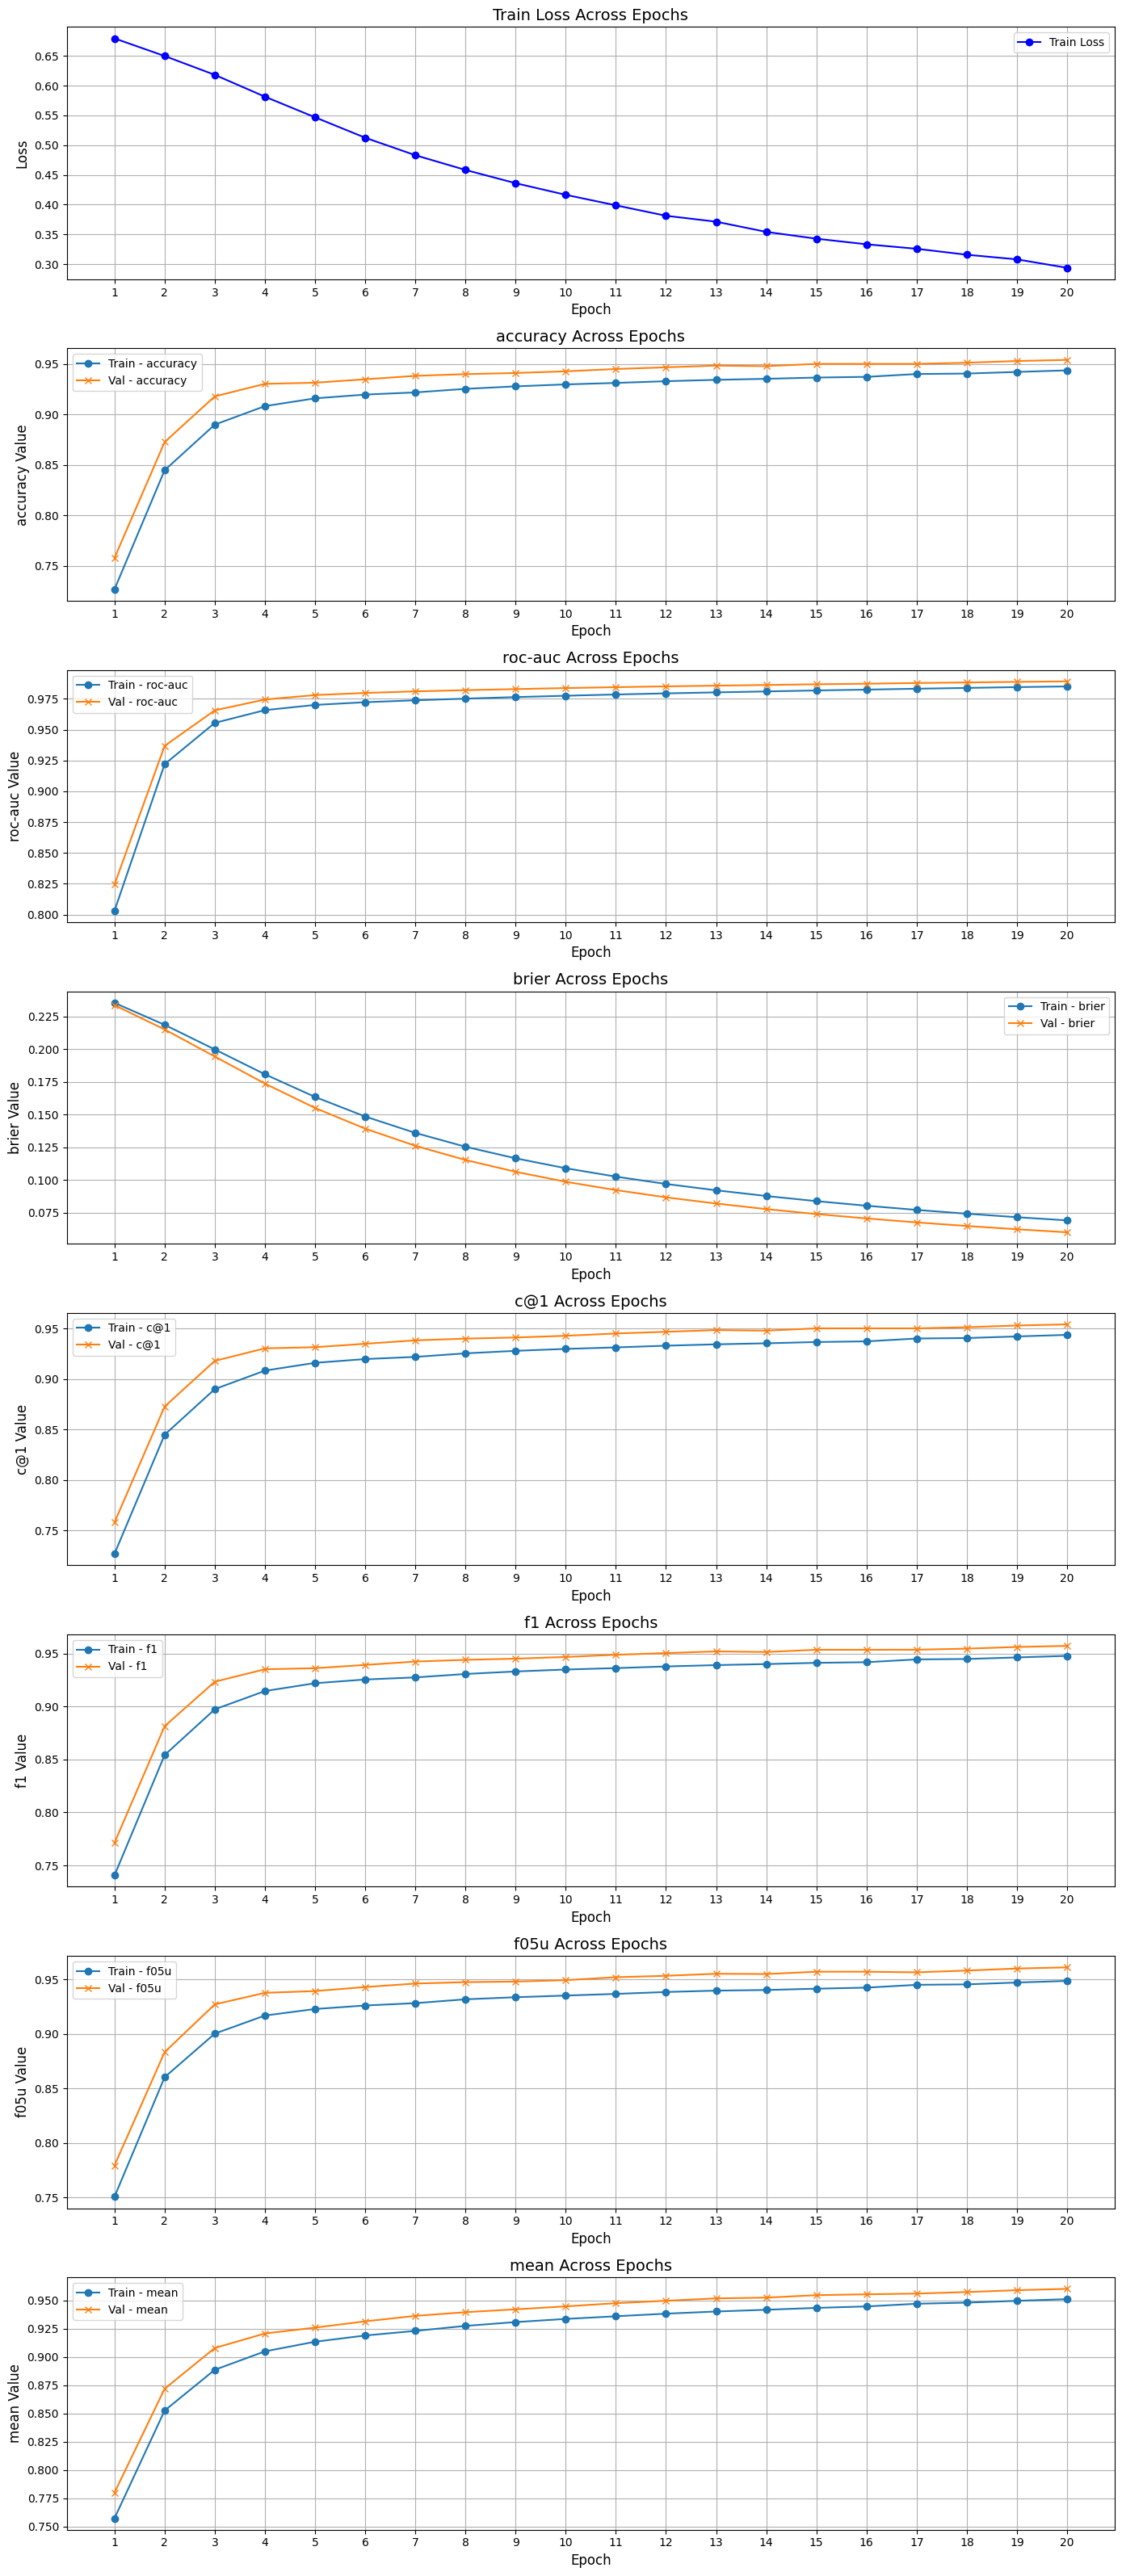

In [43]:
import matplotlib.pyplot as plt

metric_names = history["val_metrics"][0].keys()
epochs = list(range(1, len(history["val_metrics"]) + 1))

train_values = {name: [epoch.get(name, None) for epoch in history["train_metrics"]] for name in metric_names}
val_values = {name: [epoch.get(name, None) for epoch in history["val_metrics"]] for name in metric_names}

num_subplots = len(metric_names) + 1  # Number of metrics + train loss
plt.figure(figsize=(14, 4 * num_subplots))  # Increase height proportional to the number of plots

# Plot train loss
plt.subplot(num_subplots, 1, 1)

plt.plot(epochs, history["train_loss"], label="Train Loss", marker="o", color="blue")
plt.title("Train Loss Across Epochs", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.xticks(epochs)
plt.grid(True)
plt.legend()

# Plotting each metric in a separate graph
for idx, metric in enumerate(metric_names):
    plt.subplot(len(metric_names) + 1, 1, idx + 2)  # Adjust index for additional loss plot
    plt.plot(epochs, train_values[metric], label=f'Train - {metric}', marker='o')
    plt.plot(epochs, val_values[metric], label=f'Val - {metric}', marker='x')
    plt.title(f"{metric} Across Epochs", fontsize=14)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel(f"{metric} Value", fontsize=12)
    plt.xticks(epochs)
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

## Evaluate test

In [28]:
# # Load the model from the saved checkpoint
# checkpoint_path = f"models/models_individual_bert/fine_tuned_model_10_epochs_3e-05_lr_1_layers_256_batch_size_checkpoint_5.pth"
# model = torch.load(checkpoint_path)
# model.to(device)

In [29]:
# Evaluación final en el conjunto de prueba
test_metrics = evaluate(model, test_loader, device)

print("Test Metrics:")
for metric_name, value in test_metrics.items():
    print(f"  {metric_name}: {value}")

Test Metrics:
  accuracy: 0.9536199095022625
  roc-auc: 0.9898298473801285
  brier: 0.06201782592993534
  c@1: 0.9536199095022625
  f1: 0.9567510548523206
  f05u: 0.9591793570219966
  mean: 0.9594724685653546
